<a href="https://colab.research.google.com/github/4en1x/diploma/blob/master/Final8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cd /usr/src
!ln -sfn linux-headers-2.6.35-28-generic linux

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-9a__qslt
  Stored in directory: /tmp/pip-ephem-wheel-cache-431y_0h_/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin
directory /content/src already exists
Out bin /content/result.out


In [26]:
%%cu
#include <cuda_runtime.h>
#include "device_launch_parameters.h"
#include <stdlib.h>
#include <stdio.h>
#include "linux/kernel.h"
#include <iostream>
#include <ctime>
#include <iomanip>
#include <fstream>
#include <math.h>
#include <cmath>

using namespace std;

#define ITERATIONS 2000000
#define N 256

#define e 2.7182818

#define blockZSize 4

#define blockXSize 16
#define blockYSize 16

#define tileXSize 4
#define tileYSize 4

#define extN (N + 2 * blockZSize)
#define Dx 1
#define h ((float) Dx / (N + 1))
#define h2 powf(h, 2.0)

__device__
float f(int i, int j) {
	return 2 * powf(e, i * h + j * h);
}

float u_t(float x) {
	return powf(e, x);
}

float u_l(float x) {
	return powf(e, x);
}

float u_r(float x) {
	return powf(e, x + 1);
}

float u_d(float x) {
	return powf(e, x + 1);
}


__device__
void tile(float* matrix, int iGl, int jGl, bool isBlack) {
	int iBegin = iGl * blockXSize + threadIdx.x * tileXSize + blockZSize;
	int jBegin = jGl * blockYSize + threadIdx.y * tileYSize + blockZSize;

  int N1 = tileXSize + blockZSize * 2;
  int N2 = tileYSize + blockZSize * 2;
  
	float helper[12 * 12];
    
  for(int i = 0; i < N1; i++) {
		for(int j = 0; j < N2; j++) {
			helper[i * N1 + j] = matrix[extN * (iBegin - blockZSize + i) + jBegin - blockZSize + j];
		}
	}
  
  int iSplit = iBegin - 2 * blockZSize + 1;
  int jSplit = jBegin - 2 * blockZSize + 1;
    
  for(int k = 1; k < blockZSize; k++) {
		for (int i = k; i < k + tileXSize; i++) {
       
		  for (int j = k; j < k + tileXSize; j += 1) {
        int b = N1 * i + j;
			  helper[b] = 0.25 * (
            helper[b + N1]
          + helper[b - N1]
          + helper[b + 1]
				  + helper[b - 1] 
          - h2 * f(iSplit + i, jSplit + j)
        );
		  }
	  }
	}

  //printf("iGl : %d, %d, %d, %d, %d, %d, %d \n", iGl, jGl, threadIdx.x, threadIdx.y, isBlack, iBegin, jBegin);

	for (int i = iBegin; i < iBegin + tileXSize; i++) {
		
		for (int j = jBegin; j < jBegin + tileYSize; j += 1) {
      int helperIndex = N1 * (i - iBegin + blockZSize) + j - jBegin + blockZSize;
			matrix[extN * i + j] = 0.25 * (
          helper[helperIndex + N1]
        + helper[helperIndex - N1]
        + helper[helperIndex + 1]
				+ helper[helperIndex - 1] 
        - h2 * f(i - blockZSize + 1, j - blockZSize + 1)
      );
		}
	}
}

__global__
void calculateBlack(float* matrix) {
	tile(matrix, blockIdx.x, blockIdx.y, true);
}

__global__
void calculateRed(float* matrix) {
	tile(matrix, blockIdx.x, blockIdx.y, false);
}

float func(int i, int j) {
	return powf(e, i * h + j * h);
}

float* createMatrix(int row, int col) {
	float* matrix = new float[row * col];

	for(int i = 0; i < row; i++) {
		for(int j = 0; j < col; j++) {
			matrix[i * row + j] = 0;
		}
	}

  for(int k = 0; k < blockZSize; k++) {
    for(int i = k; i < row - k; i++) {
      matrix[k * row + i] = u_t((i - blockZSize + 1) * h);
      matrix[(row - 1 - k) * row + i] = u_d((i - blockZSize + 1) * h);
    }
	}

  for(int k = 0; k < blockZSize; k++) {
    for(int j = k; j < col - k; j++) {
      matrix[j * col + k] = u_l((j - blockZSize + 1) * h);
      matrix[j * col + row - 1 - k] = u_r((j - blockZSize + 1) * h);
	  }
  }
    
	return matrix;
}

float calculateDifference(float* matrix1) {
	float tolerance = 0.0f;
  for (int i = blockZSize; i < extN - blockZSize; i++) {
		for (int j = blockZSize; j < extN - blockZSize; j++) {
      float fCurrent = func(i - blockZSize + 1, j - blockZSize + 1);
      if(abs(matrix1[i * extN + j] - fCurrent) > tolerance) {
          tolerance = abs(matrix1[i * extN + j] - fCurrent);
      } 
		}
	}
	return tolerance;
}


int main() {
  ofstream myfile;
  ofstream myfiletimes;
  myfile.open("diff_8_4.txt");
  myfiletimes.open("diff_8_4_times.txt");
	float* matrixHost = createMatrix(extN, extN);
	float* matrixDevice;

	int matrixSize = sizeof(float) * extN * extN;

	cudaMalloc((void**)&matrixDevice, matrixSize);
	cudaMemcpy(matrixDevice, matrixHost, matrixSize, cudaMemcpyHostToDevice);

	long startTime = clock();
	dim3 blocks(N / blockXSize, N / blockYSize);
	dim3 threads(blockXSize / tileXSize, blockYSize / tileYSize);

	for (size_t i = 0; i < ITERATIONS; i++) {
		calculateBlack <<< blocks, threads >>>(matrixDevice);
		cudaDeviceSynchronize();
		cudaPeekAtLastError();

    if(i%1000 == 0) {
        cudaMemcpy(matrixHost, matrixDevice, matrixSize, cudaMemcpyDeviceToHost);
        float diff = calculateDifference(matrixHost);
        cout << " Difference: " << diff << "iter: " << i;
        myfile << diff << " ";
        myfiletimes << clock() - startTime << " ";
        if(diff < 0.01) break;
    }  
	}
  
	std::cout << "Calculation take time: " << clock() - startTime << std::endl;
  myfile << clock() - startTime << " ";
    
  cout << " Difference: " << calculateDifference(matrixHost);
	cudaError_t cudaResult = cudaMemcpy(matrixHost, matrixDevice, matrixSize, cudaMemcpyDeviceToHost);

	if (cudaResult != cudaSuccess) {
		std::cout << "Cuda error: " << cudaResult << std::endl;
	}

    myfile.close();
    myfiletimes.close();
	return 0;
}

' Difference: 7.27506iter: 0 Difference: 4.03278iter: 1000 Difference: 3.28314iter: 2000 Difference: 2.81016iter: 3000 Difference: 2.4259iter: 4000 Difference: 2.08669iter: 5000 Difference: 1.78861iter: 6000 Difference: 1.52956iter: 7000 Difference: 1.30606iter: 8000 Difference: 1.11491iter: 9000 Difference: 0.951559iter: 10000 Difference: 0.811921iter: 11000 Difference: 0.692767iter: 12000 Difference: 0.591054iter: 13000 Difference: 0.50431iter: 14000 Difference: 0.430302iter: 15000 Difference: 0.367125iter: 16000 Difference: 0.31318iter: 17000 Difference: 0.267121iter: 18000 Difference: 0.227795iter: 19000 Difference: 0.194219iter: 20000 Difference: 0.165552iter: 21000 Difference: 0.141076iter: 22000 Difference: 0.12018iter: 23000 Difference: 0.102341iter: 24000 Difference: 0.0871098iter: 25000 Difference: 0.0741065iter: 26000 Difference: 0.0630043iter: 27000 Difference: 0.0535259iter: 28000 Difference: 0.045433iter: 29000 Difference: 0.0385265iter: 30000 Difference: 0.032629iter: 31

Text(0, 0.5, 'Норма матрицы')

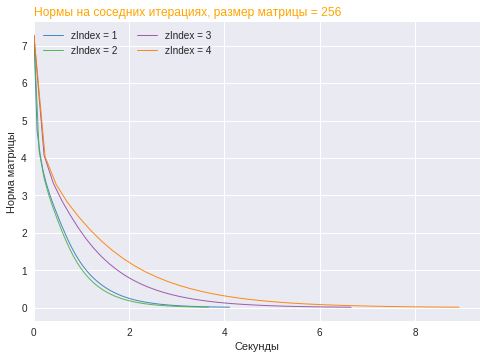

In [34]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

k = 0

c1 = list(map(lambda x: float(x), open("diff_8_1.txt", 'r').read().split(' ')[:-2]))[k:]
c2 = list(map(lambda x: float(x), open("diff_8_2.txt", 'r').read().split(' ')[:-2]))[k:]
c3 = list(map(lambda x: float(x), open("diff_8_3.txt", 'r').read().split(' ')[:-2]))[k:]
c4 = list(map(lambda x: float(x), open("diff_8_4.txt", 'r').read().split(' ')[:-2]))[k:]

t1 = list(map(lambda x: float(x) / 1000000, open("diff_8_1_times.txt", 'r').read().split(' ')[:-1]))[k:]
t2 = list(map(lambda x: float(x) / 1000000, open("diff_8_2_times.txt", 'r').read().split(' ')[:-1]))[k:]
t3 = list(map(lambda x: float(x) / 1000000, open("diff_8_3_times.txt", 'r').read().split(' ')[:-1]))[k:]
t4 = list(map(lambda x: float(x) / 1000000, open("diff_8_4_times.txt", 'r').read().split(' ')[:-1]))[k:]



# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot

plt.plot(t1, c1,  marker='', color=palette(1), linewidth=1, alpha=0.9, label='zIndex = 1')  
plt.plot(t2, c2,  marker='', color=palette(2), linewidth=1, alpha=0.9, label='zIndex = 2')  
plt.plot(t3, c3,  marker='', color=palette(3), linewidth=1, alpha=0.9, label='zIndex = 3')  
plt.plot(t4, c4,  marker='', color=palette(4), linewidth=1, alpha=0.9, label='zIndex = 4')  

# Add legend
plt.legend(loc=2, ncol=2)
plt.xlim(left=0)
# Add titles
plt.title("Нормы на соседних итерациях, размер матрицы = 256", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Секунды")
plt.ylabel("Норма матрицы")